# FMR standard problem

**Author**: Marijan Beg

**Date**: 11 May 2016

## Problem specification

We choose a cuboidal thin film permalloy sample measuring $120 \times 120 \times 10 \,\text{nm}^{3}$. The choice of a cuboid is important as it ensures that the finite difference method employed by OOMMF does not introduce errors due to irregular boundaries that cannot be discretized well. We choose the thin film geometry to be thin enough so that the variation of magnetization dynamics along the out-of-film direction can be neglected. Material parameters based on permalloy are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$,
- Gilbert damping $\alpha = 0.008$.

An external magnetic bias field with magnitude $80 \,\text{kA/m}$ is applied along the direction $e = (1, 0.715, 0)$. We choose the external magnetic field direction slightly off the sample diagonal in order to break the system’s symmetry and thus avoid degenerate eigenmodes. First, we initialize the system with a uniform out-of-plane magnetization $m_{0} = (0, 0, 1)$. The system is allowed to relax for $5 \,\text{ns}$, which was found to be sufficient time to obtain a well-converged equilibrium magnetization configuration. We refer to this stage of simulation as the relaxation stage, and its final relaxed magnetization configuration is saved to serve as the initial configuration for the next dynamic stage. Because we want to use a well defined method that is supported by all simulation tools, we minimize the system’s energy by integrating the LLG equation with a large, quasistatic Gilbert damping $\alpha = 1$ for $5 \,\text{ns}$. In the next step (dynamic stage), a simulation is started using the equilibrium magnetisation configuration from the relaxation stage as the initial configuration. Now, the direction of an external magnetic field is altered to $e = (1, 0.7, 0)$. This simulation stage runs for $T = 20 \,\text{ns}$ while the (average and spatially resolved) magnetization $M(t)$ is recorded every $\Delta t = 5 \,\text{ps}$. The Gilbert damping in this dynamic simulation stage is $\alpha = 0.008$.

Details of this standard problem specification can be found in Ref. 1.

In [1]:
!rm -rf fmr_standard_problem

In [2]:
import numpy as np

L = 120e-9  # x and y dimensions of the sample(m)
thickness = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

# Minimum sample coordinate.
cmin = (0, 0, 0)
# Maximum sample coordinate.
cmax = (L, L, thickness)
# Discretisation.
d = (dx, dy, dz)

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
H = 8e4 * np.array([0.81345856316858023, 0.58162287266553481, 0.0])

## Relaxation stage

Firstly, all required modules are imported.

In [3]:
import sys

sys.path.append('../../')

from oommfc import Sim, BoxAtlas, RectangularMesh
from oommfc.energies import UniformExchange, Demag, FixedZeeman

Now, the simulation object can be created and exchange, demagnetisation, and Zeeman energies are added.

In [4]:
# Create a BoxAtlas object.
atlas = BoxAtlas(cmin, cmax)

# Create a mesh object.
mesh = RectangularMesh(atlas, d)

# Create a simulation object.
sim = Sim(mesh, Ms, name='fmr_standard_problem')

# Add exchange energy.
sim.add(UniformExchange(A))

# Add demagnetisation energy.
sim.add(Demag())

# Add Zeeman energy.
sim.add(FixedZeeman(H))

At this point, the system is initialised in the out-of-plane direction. As an example, we use a python function. This initialisation can also be achieved using the tuple or list object.

In [5]:
# Python function for initialising the system's magnetisation.
def m_init(pos):
    return (0, 0, 1)

# Initialise the magnetisation.
sim.set_m(m_init)

# The same initialisation can be achieved using:
# sim.set_m((0, 0, 1))
# sim.set_m([0, 0, 1])
# sim.set_m(np.array([0, 0, 1]))

Finally, the system is relaxed for $5 \,\text{ns}$.

In [6]:
sim.run_until(5e-9)

We can now load the relaxed state to the Field object and plot the $z$ slice of magnetisation.

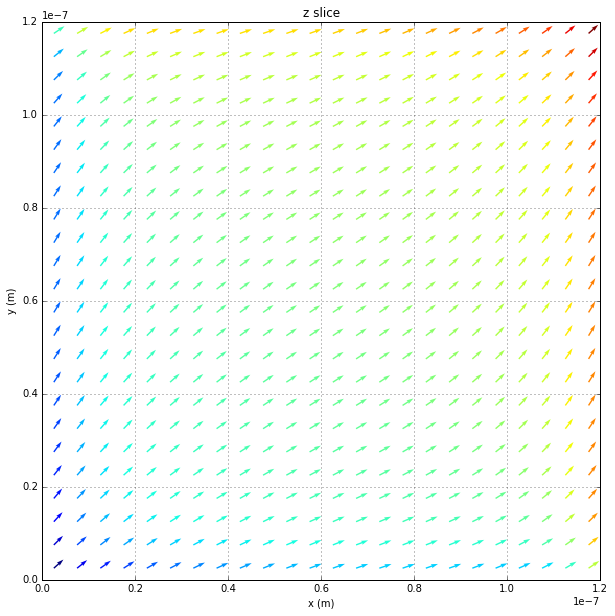

In [7]:
%matplotlib inline
fig = sim.m.plot_slice('z', 5e-9)

## Dynamic stage

In the dynamic stage, we use the relaxed state from the relaxation stage.

In [8]:
# Change external magnetic field.
H = 8e4 * np.array([0.81923192051904048, 0.57346234436332832, 0.0])
sim.set_H(H)

In this stage, the Gilbert damping is reduced.

In [9]:
sim.alpha = 0.008

Finally, we run the multiple stage simulation.

In [10]:
total_time = 20e-9
stages = 4000

sim.run_until(total_time, stages)

## Postprocessing

From the obtained vector field samples, we can compute the average of magnetisation $y$ component and plot its time evolution. 

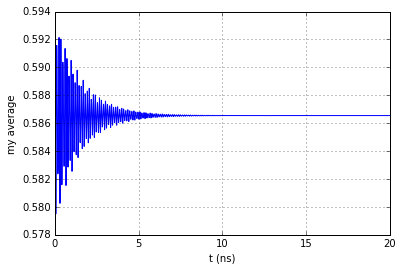

In [11]:
import glob
import matplotlib.pyplot as plt
from oommffield import read_oommf_file

# Compute the <my>
t_list = []
myav = []
for i in range(stages):
    omf_filename = glob.glob('fmr_standard_problem/fmr_standard_problem-Oxs_TimeDriver-Spin-%09d-*.omf' % i)[0]
    m_field = read_oommf_file(omf_filename)
    t_list.append(i*total_time/stages)
    myav.append(m_field.average()[1])
    
t_array = np.array(t_list)
myav = np.array(myav)

# Plot <my> time evolution.
plt.plot(t_array/1e-9, myav)
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.grid()

From the $<m_{y}>$ time evolution, we can compute and plot its Fourier transform.

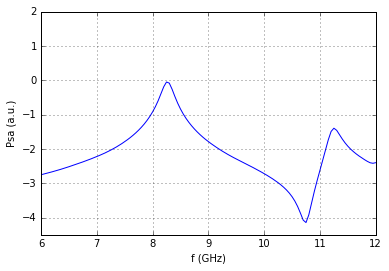

In [12]:
import scipy.fftpack

psd = np.log10(np.abs(scipy.fftpack.fft(myav))**2)
f_axis = scipy.fftpack.fftfreq(stages, d=total_time/stages)

plt.plot(f_axis/1e9, psd)
plt.xlim([6, 12])
plt.ylim([-4.5, 2])
plt.xlabel('f (GHz)')
plt.ylabel('Psa (a.u.)')
plt.grid()

## References
[1] A. Baker, M. Beg, G. Ashton, M. Albert, D. Chernyshenko, W. Wang, S. Zhang, M.-A. Bisotti, M. Franchin, C.L. Hu, R. Stamps, T. Hesjedal, and H. Fangohr, arXiv 1603.0541 (2016).